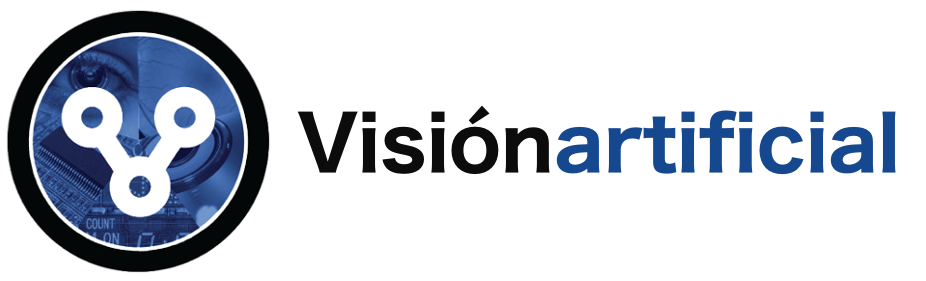

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# <font style="color:rgb(50,120,229)">Seguimento de obxectos empegando Mean-Shift e CAMshift</font>

# <font style="color:rgb(50,120,229)">Revisión</font>

Nun dos cadernos, vimos como funciona o seguimento mediante un filtro de Kalman. Neste, presentaremos o seguimento de obxectos como un problema de busca e utilizaremos un algoritmo chamado Meanshift para rastrexar o obxecto. É moi intuitivo e funciona ben para seguimento en tempo real de obxectos non ríxidos. É robusto á oclusións, ao desorde e ás pequenas variacións de escala. Realizaremos un seguimento facial como exemplo de aplicación.

Tamén discuteremos outro algoritmo para o seguimento de obxectos chamado CAMshift que está baseado en Meanshift e veremos como mellora o seguimento sobre este.


# <font style="color:rgb(50,120,229)">Seguimento de obxectos con Meanshift</font>
Discutiremos o seguimento de obxectos usando o algoritmo Meanshift.

## <font style="color:rgb(50,120,229)">Que é Meanshift?</font>


Meanshift é un enfoque non paramétrico para atopar un modo nun conxunto de puntos. Noutras palabras, atopa os máximos dunha función de densidade. Foi presentado por primeira vez por Fukunaga e Hostetler en 1975 no seu [artigo](http://ieeexplore.ieee.org/document/1055330/). Variacións do algoritmo empréganse en aplicacións como a segmentación de imaxes e o filtrado de preservación de bordes.

### <font style="color:rgb(50,120,229)">Un exemplo simple</font>

Considere o gráfico de dispersión dun conxunto de puntos que se mostra a continuación. Meanshift usa un enfoque iterativo para atopar o centro de masa ou a rexión con maior densidade. Na figura seguinte, a estrela vermella é o punto arredor do cal se calculará a media e o círculo vermello indica a rexión que se está a avaliar na presente iteración. Se pensamos nos puntos como masas, entón o centro de masa non será o mesmo que o centro do círculo. Interésanos que o centro de masas para atopar o modo dos datos. A estrela verde indica o centro de masa da rexión marcada polo círculo vermello. Vexamos como funciona.

Facemos unha estimación aleatoria para que comece a estrela vermella. Asumindo que todos os puntos teñen o mesmo peso, calcúlase o centro de masa, representado pola estrela verde. O centro do círculo desprázase ao centro de masa ao comezo da seguinte iteración. O mesmo proceso repítese ata que o centro de masa (estrela verde) non se move con respecto ao centro real (estrela vermella). Todo o proceso implica calcular e desprazar a media dun conxunto de puntos de datos e, polo tanto, chámase desplazamento medio (meanshift). A frecha negra indica a dirección e a cantidade de desprazamento da media entre iteracións e chámase vector de desprazamento da media.




| <center><img src="visuais/opcv4face-w8-m3-meanShift1stteration.png" width=500/></center> | <center><img src="visuais/opcv4face-w8-m3-meanShift2ndIteration.png" width=500/></center> | 
| -------- | -------- | 
| <center>1st Iteration</center>     | <center>2nd Iteration</center>     |
| <center><img src="visuais/opcv4face-w8-m3-meanShift3rdIteration.png" width=500/></center> | <center><img src="visuais/opcv4face-w8-m3-meanShiftConvergence.png" width=500/></center> | 
| <center>3rd Iteration</center>     | <center>Convergence</center>     |

<center>Ilustración do proceso de mean-shift. Estrela vermella - centro da rexión de interese para a iteración actual. Estrela verde - centro de masa para a rexión na iteración actual.</center>

&nbsp;

O radio do círculo, tamén chamado tamaño da xanela, é o parámetro máis importante. O modo estimado depende deste parámetro, unha ventá moi pequena xerará máximos locais, non globais e demasiado grande, non permitirá que o algoritmo atope os verdadeiros máximos. Se hai máis dun máximo, fusionaranse. Para solucionar este problema, o tamaño da xanela debe ser modificado de forma adaptativa, que é o que fai o algoritmo CAMshift - Continuously Adaptive Meanshift, que comentaremos máis adiante.

### <font style="color:rgb(50,120,229)">As ecuacións</font>

Chegando aos detalles matemáticos do proceso anterior, para o centro da xanela situado en $x$, o centro de masa calcúlase:
$$
m(x) = \frac{\sum_i{K(x − x_i)}x_i}{\sum_i{K(x − x_i)}}
$$

onde,

K é o núcleo que decide o tamaño da xanela e como se acumularán os pesos dos diferentes puntos,

$x_i$ son os puntos da vecindade,

$m(x)$ é o centro de masas,



No exemplo anterior, utilizaramos un núcleo uniforme, o que significa que todos os puntos contribúen igualmente ao centro de masa, para un determinado tamaño de xanela $d$. $K(x)$ neste caso vén dado por:

$$
K_U(x)  = \begin{cases} 1,& \text{se } ||x|| \le d \\ 0, & \text{se } ||x|| > d \end{cases}
$$


Un kernel mellor será o que dea máis importancia aos puntos que se aproximen a $x$ e decae lentamente a medida que nos alexamos. Isto conséguese usando un núcleo gaussiano ( $K_G$ ) ou un núcleo de epanechnikov ( $K_E$ ) que están dados por:

$$
K_G(x)  = \begin{cases} e^−{\frac{||x||^2}{d^2}},& \text{se } ||x|| \le d \\ 0, & \text{se } ||x|| > d \end{cases}
$$
$$
K_E(x)  = \begin{cases} 1 − \frac{||x||^2}{d^2},& \text{se } ||x|| \le d \\ 0, & \text{se } ||x|| > d \end{cases}
$$

### <font style="color:rgb(50,120,229)">Que pasa co seguimento de obxectos?</font>

Agora que vimos como Meanshift atopa os máximos dunha función de densidade, queremos aplicalo para realizar o seguimento de obxectos. Para iso, temos que modelar o seguimento de obxectos como un problema de busca de máximos. Isto pódese facer do seguinte xeito:

1. Busca o histograma de cores do obxecto de interese.

2. Para cada fotograma novo, busca unha imaxe de verosimilitude (que sexa semellante a unha función de densidade), cuxos píxeles indiquen o que se parecen á distribución da cor do obxecto de interese. Esta imaxe de probabilidade pódese obter mediante a retroproxección do histograma, que se comenta na seguinte sección.

3. Usa Meanshift para atopar os máximos desta función de densidade de imaxe de probabilidade, que dá a posición do obxecto no novo cadro.


## <font style="color:rgb(50,120,229)">Que é a retroproxección do histograma?</font>

A retroproxección do histograma é unha forma de atopar a semellanza entre dúas imaxes. Pódese definir vagamente como un método de volver a aplicar un histograma precalculado a unha nova imaxe para atopar a semellanza entre a distribución da cor da nova imaxe e o obxecto de interese. Vexamos, temos un histograma do obxecto de interese dado por **H**. Entón, para cada píxel da nova imaxe, atopa o bin en **H** ao que pertence e crea unha nova imaxe sendo o valor de píxel o valor do bin.

Por exemplo, queremos atopar a balón de cor laranxa na imaxe que se mostra na imaxe. Supoñamos que calculamos un histograma da pelota laranxa, xa que é o noso obxecto de interese. O histograma terá valores altos nos bins de cor laranxa e valores moi baixos nos contenedores doutras cores. Agora, na imaxe posterior proxectada, os píxeles pertencentes á bola laranxa terán valores moi altos e outros píxeles terán valores máis baixos como se mostra a continuación.

Deste xeito, créase unha imaxe de verosimilitude onde cada píxel representa a probabilidade de que ese píxel teña a mesma distribución de cor que a do obxecto.


| <center><img src="visuais/opcv4face-w8-m3-newFrame.png" width=500/></center> | <center><img src="visuais/opcv4face-w8-m3-backProjectedImage.png" width=500/></center> | 
| -------- | -------- | 
| <center>Novo fotograma</center>     | <center>Imaxe reproxectada</center>     | 


## <font style="color:rgb(50,120,229)">Seguimento de obxectos empregando Meanshift en OpenCV</font>

Describiremos como realizar o seguimento de obxectos, en concreto de caras, utilizando os conceptos aprendidos ata agora. A continuación vexamos o método paso a paso:

### <font style="color:rgb(50,120,229)">Paso 1 : Busca o histograma da rexión da cara</font>

En primeiro lugar, detectamos a cara usando o detector de caras da libraria Dlib. Despois calcula o histograma da rexión da cara. O espazo de cor HSV é un espazo de cor intuitivo xa que representa a cor tal e como a perciben os humanos. Así, usamos isto para calcular o histograma da rexión da cara. Usamos **só a canle Hue**. Non obstante, pódense usar tanto as canles H como S. Para isto, usamos a función [`calcHist()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html#calchist) de OpenCV para calcular o histograma e normalizalo para ter valores no intervalo [0, 255]. Hai que ter en conta que a información de cor é moi sensible ás variacións de iluminación.


### <font style="color:rgb(50,120,229)">Paso 2 : Atopamos a imaxe retroproxectada</font>

Para cada novo fotograma, convérteo ao mesmo espazo de cor usado para atopar o histograma. Atopa a imaxe proxectada posteriormente, $BP$ usando a función OpenCV [`calcBackProject()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html#calcbackproject).

### <font style="color:rgb(50,120,229)">Paso 3 : Aplica Meanshift</font>

Usa mediashift para atopar os máximos na imaxe reproxectada no entorno da posición antiga. Usamos [`meanShift()`](http://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#meanshift) a función de OpenCV para obter a nova posición. Como se explicou na sección anterior, o algoritmo atopa o modo da imaxe reproxectada que é un mapa de confianza de semellanza entre a distribución da cor do obxecto e a nova imaxe. Na seguinte figura móstranse as primeiras iteracións para un fotograma particular do proceso mean-shift.


<table>
    <tr>
        <th><center><img src="visuais/opcv4face-w8-m3-meanshiftIter1.jpg" width=500/></center></th>
        <th><center><img src="visuais/opcv4face-w8-m3-meanshiftIter2.jpg" width=500/></center></th>
    </tr>
    <tr>
        <td><center><img src="visuais/opcv4face-w8-m3-meanshiftIter3.jpg" width=500/></center></td>
        <td><center><img src="visuais/opcv4face-w8-m3-meanshiftIter4.jpg" width=500/></center></td>
    </tr>
    <tr>
        <td><center><img src="visuais/opcv4face-w8-m3-meanshiftIter5.jpg" width=500/></center></td>
        <td><center><img src="visuais/opcv4face-w8-m3-meanshiftIter6.jpg" width=500/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Iteracións do seguimento por medio de meanshift.</center> 
            <center>Observa como a ventá se move progresivamente para aproximar a cara.</center></td>
    </tr>
</table>

## <font style="color:rgb(50,120,229)">Código de seguimento Meanshift</font>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

Inicialice a fonte de vídeo e declara as variables. Le un fotograma e atopa a rexión da cara usando o detector facial Dlib. Tamén converte o rectángulo dlib en formato de rectángulo de OpenCV .

In [3]:
filename = "../data/face2.mp4"
cap = cv2.VideoCapture(filename)

# Lemos o fotograma e atopamos a cara co detector dlib
ret,frame = cap.read()

# Detectamos as caras na imaxe
faceCascade = cv2.CascadeClassifier('../data/models/haarcascade_frontalface_default.xml')

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
faces = faceCascade.detectMultiScale(frameGray,1.3,5)
x,y,w,h = faces[0]

currWindow = (x,y,w,h)

Obtén a rexión da cara e convertea ao espazo de cor HSV. Use a función inRange para eliminar o ruído espúreo e crea unha máscara que se utilizará para calcular o histograma.

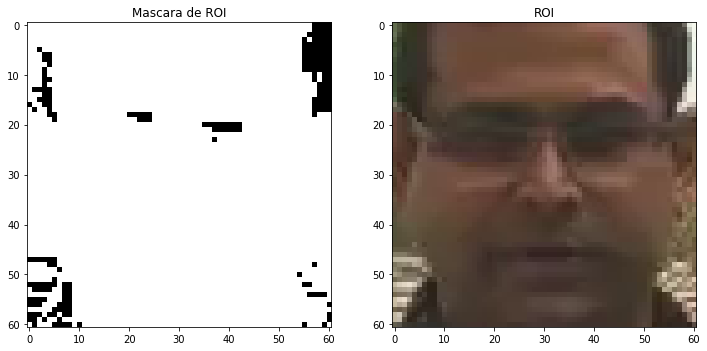

In [4]:
# conseguimos a rexión da cara na imaxe
roiObject = frame[y:y+h,x:x+w]

hsvObject =  cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

# Obter a máscara para calcular o histograma do obxecto e
# tamén elimina o ruído
mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)), 
                  np.array((180.,255.,255.)))

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title("Mascara de ROI")
plt.imshow(mask)
plt.subplot(1,2,2)
plt.title("ROI")
plt.imshow(roiObject[:,:,::-1])
plt.show()

We use 180 bins for each hue value. Use calcHist function to compute the histogram. We also normalize the histogram values to lie between and 255.

In [5]:
# Busca o histograma e normalízao para que teña valores
# entre 0 e 255
histObject = cv2.calcHist([hsvObject], [0], mask, [180], [0,180])           
cv2.normalize(histObject, histObject, 0, 255, cv2.NORM_MINMAX);

Le o fotograma e convérteo ao espazo de cor HSV e atopa a imaxe reproxectada usando o histograma calculado anteriormente.

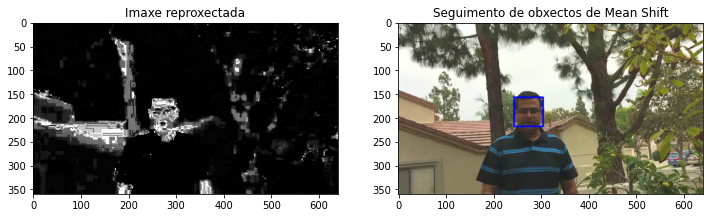

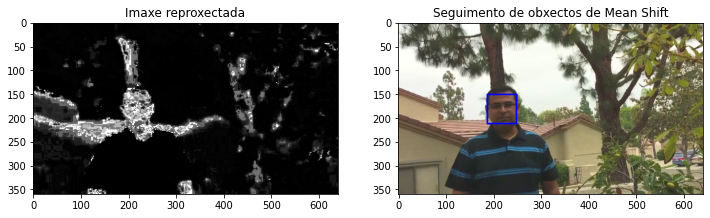

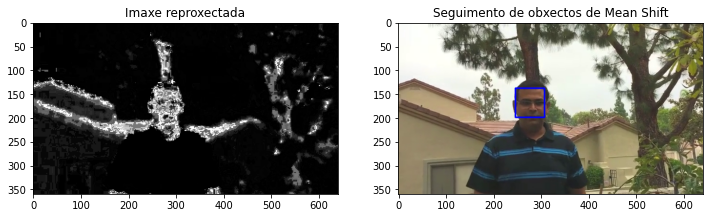

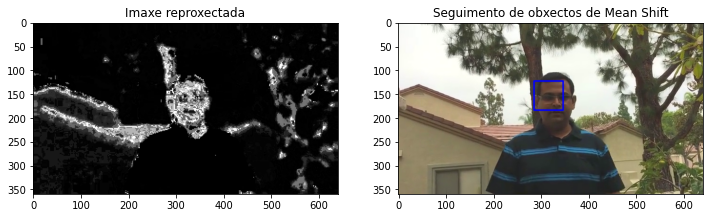

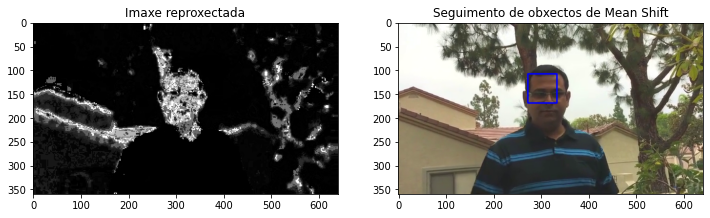

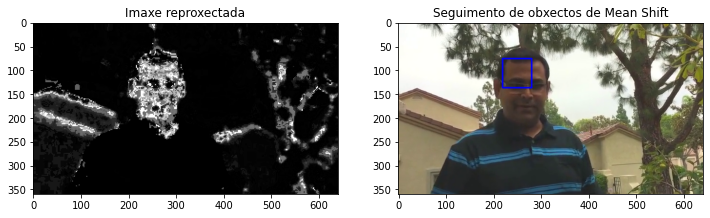

In [6]:
# Configura os criterios de terminación, polo menos 10 iteracións ou que se mova polo menos 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

# Procesaremos somaente 5 frames!
count = 0
while(1):
    ret , frame = cap.read()
    if ret == True:
        # convertemos a HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # atopar a imaxe reproxectada co histograma obtido anteriormente
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)

        # Calcular a nova xanela usando o desprazamento medio no marco actual
        ret, currWindow = cv2.meanShift(backProjectImage, currWindow, term_crit)

        # Mostra o fotograma coa localización da cara rastrexada
        x,y,w,h = currWindow
        frameClone = frame.copy()

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Imaxe reproxectada")
            cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255,0,0), 2, cv2.LINE_AA)
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('Seguimento de obxectos de Mean Shift')
            plt.show()
    else:
        break
    count += 1
    if count > 100:
        break

In [7]:
cap.release()

## <font style="color:rgb(50,120,229)">Discusión sobre o rendemento</font>

A continuación móstranse algúns fotogramas coas localizacións rastrexadas do obxecto que se visualizan mediante rectángulos.
<table>
    <tr>
        <th><center><img src="visuais/opcv4face-w8-m3-trackingResult1.jpg"/></center></th>
        <th><center><img src="visuais/opcv4face-w8-m3-TrackingResult2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="visuais/opcv4face-w8-m3-trackingResult3.jpg"/></center></td>
        <td><center><img src="visuais/opcv4face-w8-m3-trackingEsult4.jpg"/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Figura mostrando os resulatdos do tracking.</center> 
            <center>A primeira fila mostra o seguimento correcto e a segunda fila mostra casos de fallo.</center></td>
    </tr>
</table>


A primeira fila mostra que o rastreador funciona ben se hai movemento lateral con respecto á cámara. Pero cando hai un cambio na escala do obxecto, non pode detectalo xa que funciona co mesmo tamaño de xanela. No primeiro fotograma da segunda fila, o rastreador detecta a cara pero o tamaño da xanela non coincide coa cara. Veremos como se pode mellorar na seguinte sección.


# <font style="color:rgb(50,120,229)">Seguimento de obxectos empregando CAMshift</font>

CAMshift é a forma abreviada de Continuously Adaptive Meanshift. Como vimos na sección anterior, dado que Meanshift usa o mesmo tamaño de xanela, non pode detectar o obxecto se a escala cambia. CAMshift tenta solucionar este problema utilizando diferentes tamaños de xanela para achar os máximos. Foi desenvolvido por Gary Bradski en [artigo](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf) en 1998. O algoritmo CAMshift funciona do seguinte xeito:


1. Especifique a xanela de busca inicial de altura $h$ e ancho $w$ centrada en $(x_c,y_c)$.

2. Usa Meanshift para obter a localización actualizada de $(x_c,y_c)$ e almacena o momento cero que vén dado por:

$$
M_{00} = \sum_{x,y}BP(x,y)
$$

É a suma de todos os píxeles da xanela da imaxe reproxectada.


3. Move o centro da xanela ao novo centro de masa e aumenta o ancho da xanela para que sexa $w = 2\sqrt{\frac{M_{0}}{256}}$ e a altura para que sexa $h=1.2w$



4. Repite os pasos 2 e 3 ata que converxa.

A orientación da xanela do obxecto tamén se calcula empregando momentos de segunda orde. Isto pódese usar para atopar a orientación da cabeza, a lonxitude e o ancho da cara. A derivación da orientación a partir de momentos de segunda orde da imaxe reproxectada pódese atopar no [papel](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf).


## <font style="color:rgb(50,120,229)">Tracking de obxectos con CAMshift en OpenCV</font>

Seguimos os pasos 1 e 2 utilizados para o seguimento de obxectos con Meanshift. Para o terceiro paso, despois de atopar a imaxe reproxectada, usamos [`CamShift()`](https://docs.opencv.org/4.1.0/dc/d6b/group__video__track.html#gaef2bd39c8356f423124f1fe7c44d54a1) para rastrexar a posición do obxecto na nova imaxe.

`Camshift()` atopa un centro de obxectos usando meansshift e despois axusta o tamaño da xanela. Ademais, atopa a rotación óptima do obxecto. A función devolve a estrutura do rectángulo xirado que inclúe a posición, o tamaño e a orientación do obxecto. Na figura que se mostra a continuación, o rectángulo azul mostra a xanela actual de interese e o rectángulo verde mostra o rectángulo xirado.


<table>
    <tr>
        <th><center><img src="visuais/opcv4face-w8-m3-camshiftIter1.jpg"/></center></th>
        <th><center><img src="visuais/opcv4face-w8-m3-camshiftIter2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="visuais/opcv4face-w8-m3-camshiftIter3.jpg"/></center></td>
        <td><center><img src="visuais/opcv4face-w8-m3-camshiftIter4.jpg"/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Illustration of adaptive window size in CAMshift</center></td>
    </tr>
</table>

### <font style="color:rgb(50,120,229)">Improvements over Meanshift</font>

Podemos ver as melloras do uso dun tamaño de ventá adaptativo fromte ao fixo. Os casos de fallo de cambios de medios son debidamente rastreados no caso de CAMshift.

<table>
    <tr>
        <th><center><img src="visuais/opcv4face-w8-m3-camshift1.jpg"/></center></th>
        <th><center><img src="visuais/opcv4face-w8-m3-camShift2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="visuais/opcv4face-w8-m3-camShift3.jpg"/></center></td>
        <td><center><img src="visuais/opcv4face-w8-m3-camShift4.jpg"/></center></td>
    </tr>
</table>

## <font style="color:rgb(50,120,229)">Codigo do tracking de CAMshift</font>

Inicializa a fonte de vídeo e declara as variables. Le un fotograma e atopa a rexión da cara usando o detector facial Dlib. Tamén converte o rectángulo dlib nun rectángulo OpenCV.

In [8]:
filename = "../data/face1.mp4"
cap = cv2.VideoCapture(filename)
ret,frame = cap.read()

# Detectamos caras
faceCascade = cv2.CascadeClassifier('../data/models/haarcascade_frontalface_default.xml')

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
faces = faceCascade.detectMultiScale(frameGray,1.3,5)
x,y,w,h = faces[0]
currWindow = (x,y,w,h)


Obtén a rexión da cara e convertela ao espazo de cor HSV. Use a función inRange para eliminar o ruído espurio e crear unha máscara que se utilizará para calcular o histograma.


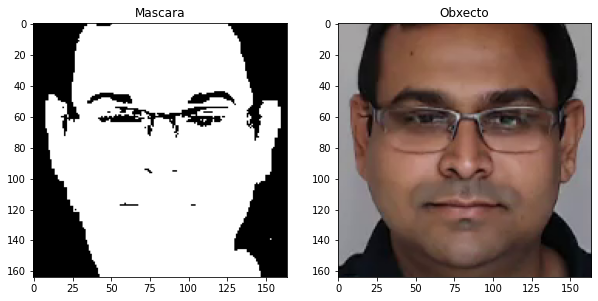

In [9]:
# obter a rexión da cara do marco
roiObject = frame[y:y+h,x:x+w]
face_height,face_width = roiObject.shape[:2]

hsvObject =  cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

# Obtén a máscara para calcular o histograma do obxecto e tamén elimina o ruído
mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)), np.array((180.,255.,255.)))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.title("Mascara")
plt.subplot(1,2,2)
plt.imshow(roiObject[:,:,::-1])
plt.title("Obxecto")
plt.show()

Usamos 180 bins para cada valor de tonalidade. Use a función calcHist para calcular o histograma. Tamén normalizamos os valores do histograma para situalos entre 0 e 255.

In [10]:
# Busca o histograma e normalízao para ter valores entre
# 0 ata 255
histObject = cv2.calcHist([hsvObject], [0],
                         mask, [180], [0,180])           
cv2.normalize(histObject, histObject,
             0, 255, cv2.NORM_MINMAX);

Le un fotograma e convérteo ao espazo de cor HSV e atopa a imaxe reproxectada usando o histograma calculado anteriormente.



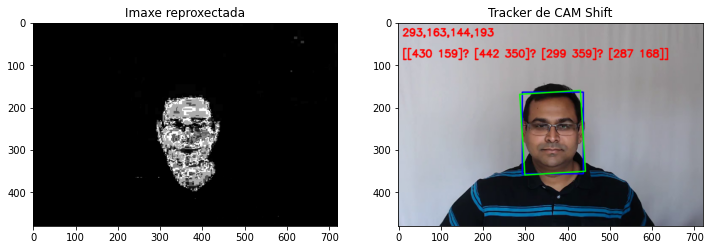

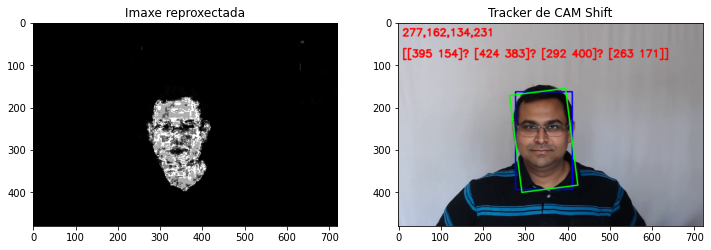

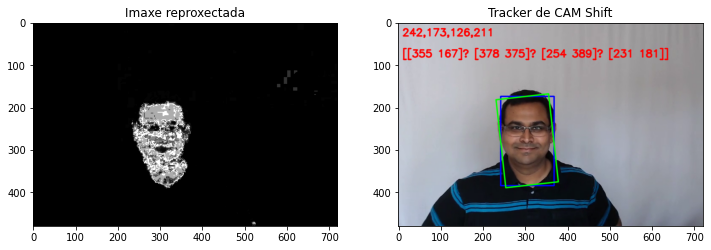

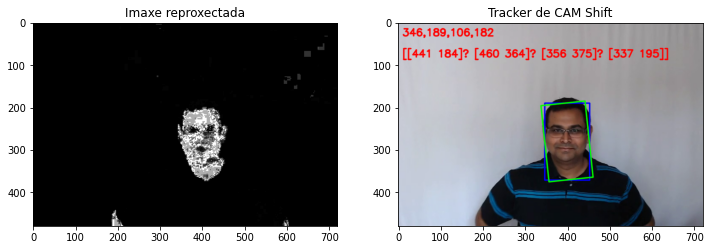

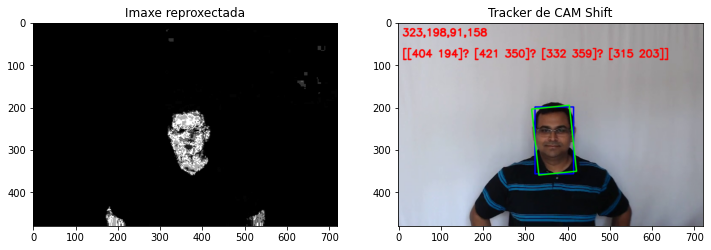

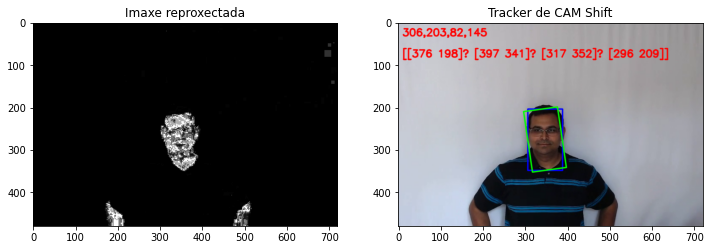

In [11]:
# Configura os criterios de terminación, xa sexa 10 iteracións ou móvese polo menos 1 punto
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
#visualozams cada 5 frames
count = 0
i=0
while(1):
    ret, frame = cap.read()
    if ret == True:
        # HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # atopar a imaxe reproxectada co histograma obtido anteriormente
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)



        # calcular a nova xanela usando CAMshift no fotograma actual
        rotatedWindow, currWindow = cv2.CamShift(backProjectImage, currWindow, term_crit)

        # establecer a xanela utilizada polo cambio medio
        x,y,w,h = currWindow

        # Obter os vértices de rotatedWindow
        rotatedWindow = cv2.boxPoints(rotatedWindow)
        rotatedWindow = np.int0(rotatedWindow)
        frameClone = frame.copy()

        # Mostra a xanela actual utilizada para o cambio medio
        cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255, 0, 0), 2, cv2.LINE_AA)

        # Mostra o rectángulo xirado coa información de orientación
        frameClone = cv2.polylines(frameClone, [rotatedWindow], True, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{},{},{},{}".format(x,y,w,h), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{}".format(rotatedWindow), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Imaxe reproxectada")
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('Tracker de CAM Shift')
            plt.show()

        i+=1
    else:
        break
    count += 1
    if count > 100:
        break

In [12]:
cap.release()

# <font style="color:rgb(50,120,229)">Referencias e lecturas complementarias</font>

1. [https://en.wikipedia.org/wiki/Mean_shift](https://en.wikipedia.org/wiki/Mean_shift)

2. [http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)